# Introduction

This lesson is a brief introduction to TOAST and its data representations.  This next cell is just initializing some things for the notebook.

In [1]:
# Load common tools for all lessons
import sys
sys.path.insert(0, "..")
from lesson_tools import (
    fake_focalplane
)

# Capture C++ output in the jupyter cells
%load_ext wurlitzer

## Runtime Environment

You can get the current TOAST runtime configuration from the "Environment" class.

In [2]:
import toast

env = toast.Environment.get()
print(env)

<toast.Environment
  Source code version = 2.3.1.dev1428
  Logging level = INFO
  Handling enabled for 0 signals:
  Max threads = 2
  MPI build enabled
  MPI runtime disabled
  Cannot use MPI on NERSC login nodes
>


## Data Model

Before using TOAST for simulation or analysis, it is important to discuss how data is stored in memory and how that data can be distributed among many processes to parallelize large workflows.

First, let's create a fake focalplane of detectors to use throughout this example.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Generate a fake focalplane with 7 pixels, each with 2 detectors.

fp = fake_focalplane()

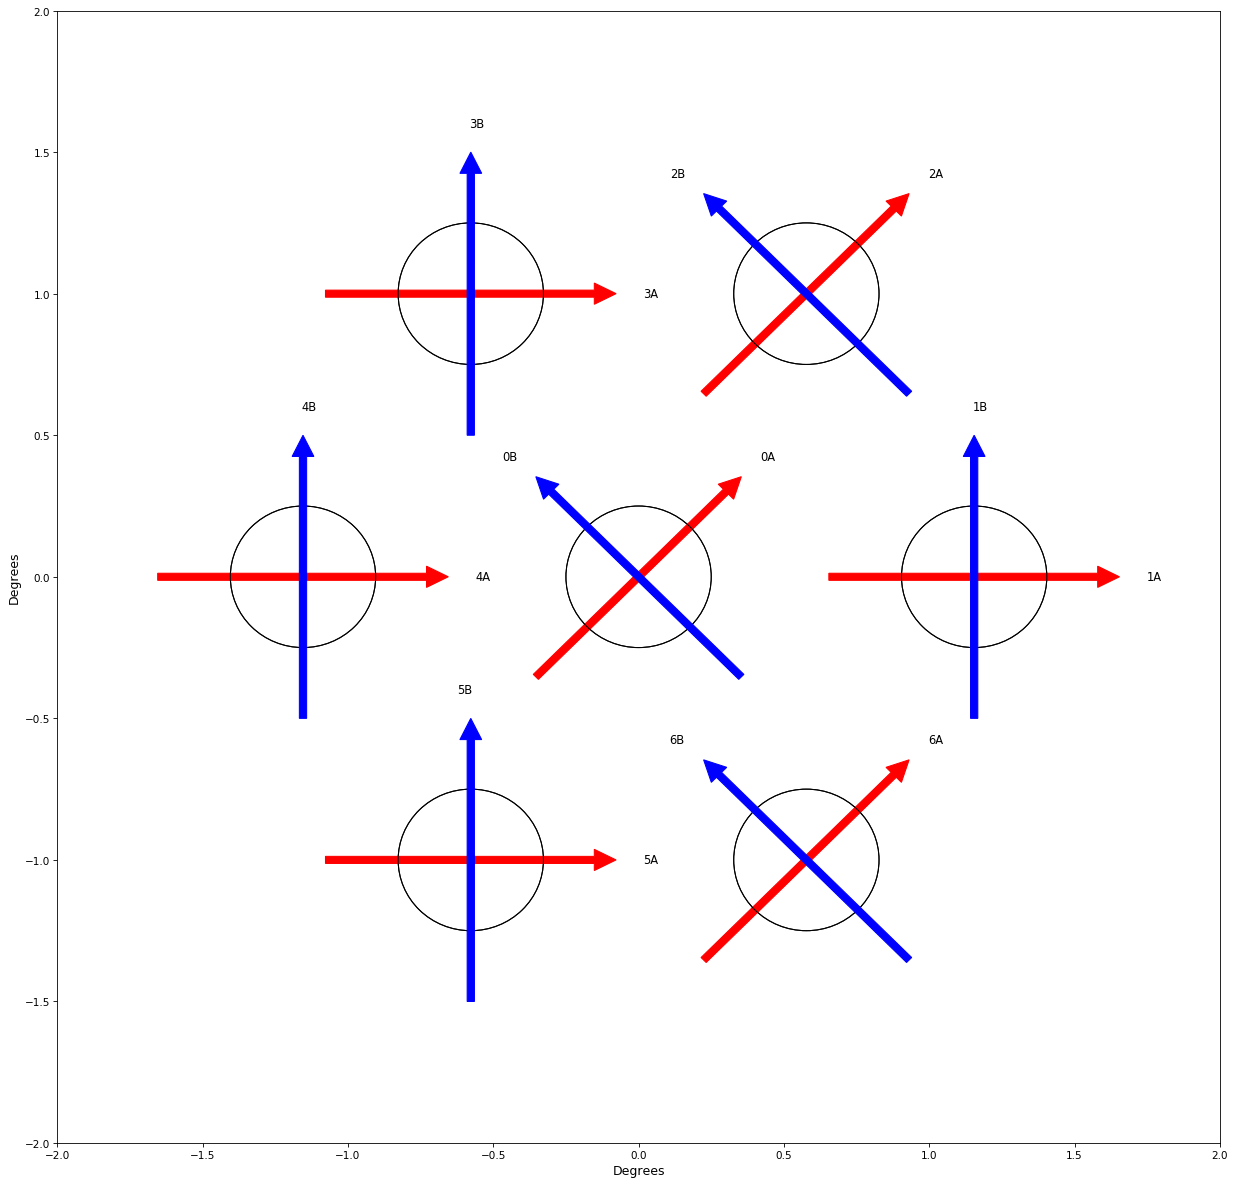

In [5]:
# Make a plot of this focalplane layout.

detnames = list(sorted(fp.keys()))
detquat = {x: fp[x]["quat"] for x in detnames}
detfwhm = {x: fp[x]["fwhm_arcmin"] for x in detnames}
detlabels = {x: x for x in detnames}
detpolcol = {x: "red" if i % 2 == 0 else "blue" for i, x in enumerate(detnames)}

toast.tod.plot_focalplane(
    detquat, 4.0, 4.0, None, fwhm=detfwhm, polcolor=detpolcol, labels=detlabels
);
# circle is aprox the fwhm of the beam

### Observations with Time Ordered Data

TOAST works with data organized into *observations*.  Each observation is independent of any other observation.  An observation consists of co-sampled detectors for some span of time.  The intrinsic detector noise is assumed to be stationary within an observation.  Typically there are other quantities which are constant for an observation (e.g. elevation, weather conditions, satellite spin axis, etc).

An observation is just a dictionary with at least one member ("tod") which is an instance of a class that derives from the `toast.TOD` base class.

The inputs to a TOD class constructor are at least:

1. The detector names for the observation.
2. The number of samples in the observation.
3. The geometric offset of the detectors from the boresight.
4. Information about how detectors and samples are distributed among processes.  More on this below.

The TOD class can act as a storage container for different "flavors" of timestreams as well as a source and sink for the observation data (with the read_\*() and write_\*() methods):

In [6]:
import toast.qarray as qa

nsamples = 1000

obs = dict()
obs["name"] = "20191014_000"

In [7]:
# The type of TOD class is usually specific to the data processing job.
# For example it might be one of the simulation classes or it might be
# a class that loads experiment data.  Here we just use a simple class
# that is only used for testing and which reads / writes data to internal memory
# buffers.

tod = toast.tod.TODCache(None, detnames, nsamples, detquats=detquat)
obs["tod"] = tod

In [8]:
# Print the tod to get summary info:
print(tod)

<TODCache
  14 total detectors and 1000 total samples
  Using MPI communicator None
    In grid dimensions 1 sample ranks x 1 detranks
  Process at (0, 0) in grid has data for:
    Samples 0 - 999 (inclusive)
    Detectors:
      0A
      0B
      1A
      1B
      2A
      2B
      3A
      3B
      4A
      4B
      5A
      5B
      6A
      6B
    Cache contains 0 bytes
>


In [9]:
# The TOD class has methods to get information about the data:

print("TOD has detectors {}".format(", ".join(tod.detectors)))
print("TOD has {} total samples for each detector".format(tod.total_samples))

TOD has detectors 0A, 0B, 1A, 1B, 2A, 2B, 3A, 3B, 4A, 4B, 5A, 5B, 6A, 6B
TOD has 1000 total samples for each detector


In [10]:
# Write some data.  Not every TOD derived class supports writing (for example,
# TOD classes that represent simulations).

t_delta = 1.0 / fp[detnames[0]]["rate"]
tod.write_times(stamps=np.arange(0.0, nsamples * t_delta, t_delta))
tod.write_boresight(
    data=qa.from_angles(
        (np.pi / 2) * np.ones(nsamples),
        (2 * np.pi / nsamples) * np.arange(nsamples),
        np.zeros(nsamples)
    )
)
for d in detnames:
    tod.write(detector=d, data=np.random.normal(scale=fp[d]["NET"], size=nsamples))
    tod.write_flags(detector=d, flags=np.zeros(nsamples, dtype=np.uint8))

In [11]:
# Read it back

print("TOD timestamps = {} ...".format(tod.read_times()[:5]))
print("TOD boresight = \n{} ...".format(tod.read_boresight()[:5,:]))
for d in detnames:
    print("TOD detector {} = {} ...".format(d, tod.read(detector=d, n=5)))
    print("TOD detector {} flags = {} ...".format(d, tod.read_flags(detector=d, n=5)))

TOD timestamps = [0.   0.05 0.1  0.15 0.2 ] ...
TOD boresight = 
[[ 7.07106781e-01  0.00000000e+00  7.07106781e-01  1.11022302e-16]
 [ 7.07103292e-01  2.22143781e-03  7.07103292e-01 -2.22143781e-03]
 [ 7.07092824e-01  4.44285371e-03  7.07092824e-01 -4.44285371e-03]
 [ 7.07075377e-01  6.66422575e-03  7.07075377e-01 -6.66422575e-03]
 [ 7.07050951e-01  8.88553201e-03  7.07050951e-01 -8.88553201e-03]] ...
TOD detector 0A = [ 0.01284852  0.21957794 -0.82436517 -0.29412479 -0.80267807] ...
TOD detector 0A flags = [0 0 0 0 0] ...
TOD detector 0B = [ 0.36777263 -3.39838578  0.81208985  0.64470285 -0.48625648] ...
TOD detector 0B flags = [0 0 0 0 0] ...
TOD detector 1A = [ 0.21409114 -0.18443383  0.87033061 -0.35808152  1.72895129] ...
TOD detector 1A flags = [0 0 0 0 0] ...
TOD detector 1B = [-1.10869333  1.58052633 -0.64277473  0.49905831 -2.47662292] ...
TOD detector 1B flags = [0 0 0 0 0] ...
TOD detector 2A = [ 0.14066628 -1.97686654 -0.21525281  1.22224187  0.48355552] ...
TOD detector 2A

In [12]:
# Store some data in the cache.  The "cache" member variable looks like a dictionary of
# numpy arrays, but the memory used is allocated in C, so that we can actually clear
# these buffers when needed.

for d in detnames:
    processed = tod.read(detector=d)
    processed /= 2.0
    # By convention, we usually name buffers in the cache by <prefix>_<detector>
    tod.cache.put("processed_{}".format(d), processed)
print("TOD cache now contains {} bytes".format(tod.cache.report(silent=True)))

TOD cache now contains 278000 bytes


### Comm : Groups of Processes

A toast.Comm instance takes the global number of processes available (MPI.COMM_WORLD) and divides them into groups.  Each process group is assigned one or more observations.  Since observations are independent, this means that different groups can be independently working on separate observations in parallel.  It also means that inter-process communication needed when working on a single observation can occur with a smaller set of processes.

At NERSC, this notebook is running on a login node, so we cannot use MPI.  Constructing a default `toast.Comm` whenever MPI use is disabled will just produce a single group of one process.  See the parallel example at the end of this notebook for a case with multiple groups.

Note- different observations are entirely unrelated, they can be made by different telescopes even

In [13]:
comm = toast.Comm()
print(comm)

<toast.Comm
  World MPI communicator = None
  World MPI size = 1
  World MPI rank = 0
  Group MPI communicator = None
  Group MPI size = 1
  Group MPI rank = 0
  Rank MPI communicator = None
>


### Data : a Collection of Observations

A toast.Data instance is mainly just a list of observations.  However remember that each process group will have a different list.  Since we have only one group of one process, this example is not so interesting.  See the parallel case at the end of the notebook.

Note - each procress group works on its set of observations independenty. EG 10 obs and 4 process groups then all four work independently for a while and then lastly globaly communicate for something like final map making. So far this notebook is entirely serial and not parallel at all

In [14]:
data = toast.Data(comm)
data.obs.append(obs)

### Data Distribution

Recapping previous sections, we have some groups of processes, each of which has a set of observations.  Within a single process group, the detector data is distributed across the processes within the group.  That distribution is controlled by the size of the communicator passed to the TOD class, and also by the `detranks` parameter of the constructor.  This detranks number sets the dimension of the process grid in the detector direction.  For example, a value of "1" means that every process has all detectors for some span of time.  A value equal to the size of the communicator results in every process having some number of detectors for the entire observation.  The detranks parameter must divide evenly into the number of processes in the communicator and determines how the processes are arranged in a grid.

As a concrete example, imagine that MPI.COMM_WORLD has 24 processes.  We split this into 4 groups of 6 procesess.  There are 6 observations of varying lengths and every group has one or 2 observations.  Here is a picture of what data each process would have.  The global process number is shown as well as the rank within the group:
<img src="toast_data_dist.png">
The parallel script at the bottom of this notebook has further examples of data distribution.

Note- a given process has a slice of each observation? Given a bunch of instructions and a given number of groups/workers is can more or less load balence to give each worker an equalish number of work which makes sense to be grouped together for minimar inter group communication

## Utilities

There are many utilities in the TOAST package that use compiled code "under the hood".  These include:

- `toast.rng`:  Streamed random number generation, with support for generating random samples from any location within a stream.

- `toast.qarray`:  Vectorized quaternion operations.

- `toast.fft`:  API Wrapper around different vendor FFT packages.

- `toast.cache`:  Class for dictionary of C-allocated numpy arrays.

- `toast.healpix`:  Subset of pixel projection routines, simd vectorized and threaded.

- `toast.timing`:  Simple serial timers, global named timers per process, a decorator to time calls to functions, and MPI tools to gather timing statistics from multiple processes.


### Random Number Example

Here is a quick example of a threaded generation of random numbers drawn from a unit-variance gaussian distribution.  Note the "key" pair of uint64 values and the first value of the "counter" pair determine the stream, and the second value of the counter pair is effectively the sample in that stream.  We can drawn randoms from anywhere in the stream in a reproducible fashion (i.e. this random generator is stateless).  Under the hood, this uses the Random123 package on each thread.

In [15]:
import toast.rng as rng

# Number of random samples
nrng = 10

In [16]:
# Draw randoms from the beginning of a stream
rng1 = rng.random(
    nrng, key=[12, 34], counter=[56, 0], sampler="gaussian", threads=True
)

In [17]:
# Draw randoms from some later starting point in the stream
rng2 = rng.random(
    nrng, key=[12, 34], counter=[56, 4], sampler="gaussian", threads=True
)

In [18]:
# The returned objects are buffer providers, so can be used like a numpy array.
print("Returned RNG buffers:")
print(rng1)
print(rng2)

Returned RNG buffers:
<AlignedF64 10 elements: -1.93456 0.0142729 ... 1.00982 0.190195>
<AlignedF64 10 elements: -0.661366 0.0715733 ... -0.696467 1.31699>


In [19]:
# Compare the elements.  Note how the overlapping sample indices match.  The
# randoms drawn for any given sample agree regardless of the starting sample.
print("------ rng1 ------")
for i in range(nrng):
    print("rng1 {}:  {}".format(i, rng1[i]))
print("------ rng2 ------")
for i in range(nrng):
    print("rng2 {}:  {}".format(i + 4, rng2[i]))

------ rng1 ------
rng1 0:  -1.9345557154123538
rng1 1:  0.014272943598316932
rng1 2:  0.45226011897093527
rng1 3:  -1.957844901847933
rng1 4:  -0.6613662026904461
rng1 5:  0.07157330335682659
rng1 6:  -0.6785937530814287
rng1 7:  1.1896892565821966
rng1 8:  1.0098155098534913
rng1 9:  0.1901951884823849
------ rng2 ------
rng2 4:  -0.6613662026904461
rng2 5:  0.07157330335682659
rng2 6:  -0.6785937530814287
rng2 7:  1.1896892565821966
rng2 8:  1.0098155098534913
rng2 9:  0.1901951884823849
rng2 10:  0.04850349309129753
rng2 11:  0.6481059989834956
rng2 12:  -0.6964671519913512
rng2 13:  1.3169924602685523


### Quaternion Array Example

The quaternion manipulation functions internally attempt to improve performance using OpenMP SIMD directives and threading in cases where it makes sense.  The Python API is modelled after the quaternionarray package (https://github.com/zonca/quaternionarray/).  There are functions for common operations like multiplying quaternion arrays, rotating arrays of vectors, converting to and from angle representations, SLERP, etc.


WHAT ARE QUATERNIONS?

links from gitter chat

https://www.cct.lsu.edu/~fharhad/ganbatte/siggraph2007/CD1/content/courses/c20/c20.pdf

https://eater.net/quaternions

https://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/19770024290.pdf

https://marctenbosch.com/quaternions/

https://en.wikipedia.org/wiki/Quaternions_and_spatial_rotation

In [20]:
import toast.qarray as qa

# Number points for this example

nqa = 5

In [21]:
# Make some fake rotation data by sweeping through theta / phi / pa angles

theta = np.linspace(0.0, np.pi, num=nqa)
phi = np.linspace(0.0, 2 * np.pi, num=nqa)
pa = np.zeros(nqa)
print("----- input angles -----")
print("theta = ", theta)
print("phi = ", phi)
print("pa = ", pa)

----- input angles -----
theta =  [0.         0.78539816 1.57079633 2.35619449 3.14159265]
phi =  [0.         1.57079633 3.14159265 4.71238898 6.28318531]
pa =  [0. 0. 0. 0. 0.]


In [22]:
# Convert to quaternions

quat = qa.from_angles(theta, phi, pa)

print("\n----- output quaternions -----")
print(quat)


----- output quaternions -----
[[ 0.00000000e+00  0.00000000e+00  1.00000000e+00  2.22044605e-16]
 [ 2.70598050e-01  2.70598050e-01  6.53281482e-01 -6.53281482e-01]
 [ 0.00000000e+00  7.07106781e-01  1.11022302e-16 -7.07106781e-01]
 [-6.53281482e-01  6.53281482e-01 -2.70598050e-01 -2.70598050e-01]
 [-1.00000000e+00  1.11022302e-16 -6.12323400e-17 -1.84889275e-32]]


In [23]:
# Use these to rotate a vector

zaxis = np.array([0.0, 0.0, 1.0])
zrot = qa.rotate(quat, zaxis)

print("\n---- Z-axis rotated by quaternions ----")
print(zrot)


---- Z-axis rotated by quaternions ----
[[ 0.00000000e+00  0.00000000e+00  1.00000000e+00]
 [ 0.00000000e+00  7.07106781e-01  7.07106781e-01]
 [-1.00000000e+00  1.57009246e-16  2.22044605e-16]
 [-2.77555756e-16 -7.07106781e-01 -7.07106781e-01]
 [ 1.22464680e-16 -5.05741657e-32 -1.00000000e+00]]


In [24]:
# Rotate different vector by each quaternion

zout = qa.rotate(quat, zrot)

print("\n---- Arbitrary vectors rotated by quaternions ----")
print(zout)


---- Arbitrary vectors rotated by quaternions ----
[[ 0.00000000e+00  0.00000000e+00  1.00000000e+00]
 [ 7.07106781e-01  5.00000000e-01  5.00000000e-01]
 [-4.44089210e-16  3.14018492e-16 -1.00000000e+00]
 [ 7.07106781e-01  5.00000000e-01  5.00000000e-01]
 [ 0.00000000e+00  7.39557099e-32  1.00000000e+00]]


In [25]:
# Multiply two quaternion arrays

qcopy = np.array(quat)
qout = qa.mult(quat, qcopy)

print("\n---- Product of two quaternion arrays ----")
print(qout)


---- Product of two quaternion arrays ----
[[ 0.00000000e+00  0.00000000e+00  4.44089210e-16 -1.00000000e+00]
 [-3.53553391e-01 -3.53553391e-01 -8.53553391e-01 -1.46446609e-01]
 [ 0.00000000e+00 -1.00000000e+00 -1.57009246e-16  2.22044605e-16]
 [ 3.53553391e-01 -3.53553391e-01  1.46446609e-01 -8.53553391e-01]
 [ 3.69778549e-32  0.00000000e+00  0.00000000e+00 -1.00000000e+00]]


In [26]:
# SLERP quaternions

qtime = 3.0 * np.arange(nqa)
qtargettime = np.arange(3.0 * (nqa - 1) + 1)
qslerped = qa.slerp(qtargettime, qtime, quat)

print("\n---- SLERP input ----")
for t, q in zip(qtime, quat):
    print("t = {} : {}".format(t, q))
    
print("\n---- SLERP output ----")
for t, q in zip(qtargettime, qslerped):
    print("t = {} : {}".format(t, q))


---- SLERP input ----
t = 0.0 : [0.00000000e+00 0.00000000e+00 1.00000000e+00 2.22044605e-16]
t = 3.0 : [ 0.27059805  0.27059805  0.65328148 -0.65328148]
t = 6.0 : [ 0.00000000e+00  7.07106781e-01  1.11022302e-16 -7.07106781e-01]
t = 9.0 : [-0.65328148  0.65328148 -0.27059805 -0.27059805]
t = 12.0 : [-1.00000000e+00  1.11022302e-16 -6.12323400e-17 -1.84889275e-32]

---- SLERP output ----
t = 0.0 : [0.00000000e+00 0.00000000e+00 1.00000000e+00 2.22044605e-16]
t = 1.0 : [ 0.10093174  0.10093174  0.95929668 -0.24367078]
t = 2.0 : [ 0.19364697  0.19364697  0.84050023 -0.46750515]
t = 3.0 : [ 0.27059805  0.27059805  0.65328148 -0.65328148]
t = 4.0 : [ 0.19364697  0.45739433  0.46750515 -0.7312525 ]
t = 5.0 : [ 0.10093174  0.60695567  0.24367078 -0.74969471]
t = 6.0 : [ 0.00000000e+00  7.07106781e-01  1.11022302e-16 -7.07106781e-01]
t = 7.0 : [-0.24367078  0.74969471 -0.10093174 -0.60695567]
t = 8.0 : [-0.46750515  0.7312525  -0.19364697 -0.45739433]
t = 9.0 : [-0.65328148  0.65328148 -0.27

### FFT Example

The internal FFT functions in TOAST are very limited and focus only on batched 1D Real FFTs.  These are used for simulated noise generation and timestream filtering.  Internally the compiled code can use either FFTW or MKL for the backend calculation.

In [27]:
# Number of batched FFTs

nbatch = 5

# FFT length

nfft = 65536

In [28]:
# Create some fake data

infft = np.zeros((nbatch, nfft), dtype=np.float64)
for b in range(nbatch):
    infft[b, :] = rng.random(nfft, key=[0, 0], counter=[b, 0], sampler="gaussian")

print("----- FFT input -----")
print(infft)

----- FFT input -----
[[ 0.70824414  0.37958204 -0.62191667 ...  0.77954278  1.12705665
   0.21430745]
 [ 0.61372834  0.68541016 -0.82076732 ... -0.10495521 -0.09820802
   0.1019775 ]
 [-0.25952652 -0.41435533  0.57094265 ...  0.32334547  2.15186219
  -0.10320734]
 [-0.18910596 -1.50802991 -1.65130707 ...  0.42610591  1.17170788
   1.54472861]
 [-1.4962988  -0.00235431 -1.50373344 ...  0.97027549  0.94612694
   0.80572723]]


In [29]:
# Forward FFT

outfft = toast.fft.r1d_forward(infft)

print("\n----- FFT output -----")
print(outfft)


----- FFT output -----
[[ 428.42060388 -138.03674787 -181.0470772  ... -403.91871131
   -80.09506675 -210.21894707]
 [-236.80183938 -293.36911153 -299.89827436 ... -265.36475328
    79.30045561 -152.79215102]
 [ 407.62843731 -321.18213065  149.8744358  ...  115.39517
   161.42894263   -8.53315689]
 [-353.92938439 -163.58217755  199.29345241 ...   41.98100849
  -151.62213508  227.94024389]
 [-287.73541094  -94.54962966  -41.95149462 ...  121.73873742
   200.54675492  233.86103108]]


In [30]:
# Reverse FFT

backfft = toast.fft.r1d_backward(outfft)

print("\n----- FFT inverse output -----")
print(backfft)


----- FFT inverse output -----
[[ 0.70824414  0.37958204 -0.62191667 ...  0.77954278  1.12705665
   0.21430745]
 [ 0.61372834  0.68541016 -0.82076732 ... -0.10495521 -0.09820802
   0.1019775 ]
 [-0.25952652 -0.41435533  0.57094265 ...  0.32334547  2.15186219
  -0.10320734]
 [-0.18910596 -1.50802991 -1.65130707 ...  0.42610591  1.17170788
   1.54472861]
 [-1.4962988  -0.00235431 -1.50373344 ...  0.97027549  0.94612694
   0.80572723]]


### Cache Example

The Cache class provides a mechanism to work around the Python memory pool.  There are times when we want to allocate memory and explicitly free it without waiting for garbage collection.  Every instance of a `toast.Cache` acts as a dictionary of numpy arrays.  Internally, the memory of each entry is a flat-packed std::vector with a custom allocator that ensures aligned memory allocation.  Aligned memory is required for SIMD operations both in TOAST and in external libraries.  Buffers in a Cache instance can be used directly for such operations.

In [31]:
from toast.cache import Cache

# Example array dimensions

cnames = ["c1", "c2"]
cshapes = {
    "c1" : (20,),
    "c2" : (2, 3, 2)
}
ctyps = {
    "c1" : np.float64,
    "c2" : np.uint16
}

In [32]:
# A cache instance

cache = Cache()

In [33]:
# Create some empty arrays in the cache

for cn in cnames:
    cache.create(cn, ctyps[cn], cshapes[cn])

print("---- Cache object ----")
print(cache)
print("\n---- Now contains ----")
for cn in cnames:
    print("{}:  {}".format(cn, cache.reference(cn)))
print("Size = ", cache.report(silent=True), " bytes")

---- Cache object ----

---- Now contains ----
c1:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
c2:  [[[0 0]
  [0 0]
  [0 0]]

 [[0 0]
  [0 0]
  [0 0]]]
Size =  184  bytes


In [34]:
# Fill existing buffers

# Get a reference to the buffer
cdata = cache.reference("c1")

# Assign elements.
cdata[:] = np.random.random(cshapes["c1"])

# Delete the reference
del cdata

In [35]:
cdata = cache.reference("c2")
idx = 0
for x in range(cshapes["c2"][0]):
    for y in range(cshapes["c2"][1]):
        for z in range(cshapes["c2"][2]):
            cdata[x, y, z] = idx
            idx += 1
del cdata
    
print("\n---- Contents after filling ----")
for cn in cnames:
    print("{}:  {}".format(cn, cache.reference(cn)))
print("Size = ", cache.report(silent=True), " bytes")


---- Contents after filling ----
c1:  [0.08461997 0.25179664 0.14678176 0.54007474 0.41888455 0.55355697
 0.84378086 0.14610015 0.51625693 0.9794042  0.45156043 0.35786292
 0.4542768  0.08690029 0.53186618 0.65296678 0.96044076 0.65704667
 0.16612424 0.79598411]
c2:  [[[ 0  1]
  [ 2  3]
  [ 4  5]]

 [[ 6  7]
  [ 8  9]
  [10 11]]]
Size =  184  bytes


In [36]:
# We can also "put" existing numpy arrays which will then be copied into
# the cache

np1 = np.random.normal(size=10)
np2 = np.random.randint(0, high=255, dtype=np.uint16, size=12).reshape((2, 3, 2))

cache.put("p1", np1)
cache.put("p2", np2)

print("\n---- Contents after putting numpy arrays ----")

for cn in list(cache.keys()):
    print("{}:  {}".format(cn, cache.reference(cn)))
print("Size = ", cache.report(silent=True), " bytes")


---- Contents after putting numpy arrays ----
c1:  [0.08461997 0.25179664 0.14678176 0.54007474 0.41888455 0.55355697
 0.84378086 0.14610015 0.51625693 0.9794042  0.45156043 0.35786292
 0.4542768  0.08690029 0.53186618 0.65296678 0.96044076 0.65704667
 0.16612424 0.79598411]
c2:  [[[ 0  1]
  [ 2  3]
  [ 4  5]]

 [[ 6  7]
  [ 8  9]
  [10 11]]]
p1:  [ 0.32778118 -0.83147924  0.52259469 -0.45510487 -1.63689182 -0.77310898
  0.6169013  -0.40577144  1.69644129 -0.03390247]
p2:  [[[121 199]
  [  2 249]
  [143 124]]

 [[122  29]
  [ 67  41]
  [ 97   8]]]
Size =  288  bytes


## Running the Test Suite

TOAST includes extensive tests built in to the package.  Running all of them takes some time, but you can also run just one test by specifying the name of the file in the toast/tests directory (without the ".py" extension):

In [37]:
import toast.tests

# Run just a couple simple tests in toast/tests/env.py
toast.tests.run("env")


test_comm (toast.tests.env.EnvTest) ... 

<toast.Comm
  World MPI communicator = None
  World MPI size = 1
  World MPI rank = 0
  Group MPI communicator = None
  Group MPI size = 1
  Group MPI rank = 0
  Rank MPI communicator = None
>


ok 
test_env (toast.tests.env.EnvTest) ... 

<toast.Environment
  Source code version = 2.3.1.dev1428
  Logging level = INFO
  Handling enabled for 0 signals:
  Max threads = 2
  MPI build enabled
  MPI runtime disabled
  Cannot use MPI on NERSC login nodes
>


ok 

----------------------------------------------------------------------
Ran 2 tests in 0.004s

OK


0

In [38]:
# Now run **ALL** the (serial) tests
toast.tests.run()


test_comm (toast.tests.env.EnvTest) ... 

Note: Google Test filter = TOAST*
[==========] Running 46 tests from 9 test cases.
[----------] Global test environment set-up.
[----------] 2 tests from TOASTenvTest
[ RUN      ] TOASTenvTest.print
TOAST ENV: Source code version = 2.3.1.dev1428
TOAST ENV: Logging level = INFO
TOAST ENV: Handling enabled for 0 signals:
TOAST ENV: Max threads = 2
TOAST ENV: MPI build enabled
TOAST ENV: MPI runtime disabled
TOAST ENV: Cannot use MPI on NERSC login nodes
[       OK ] TOASTenvTest.print (0 ms)
[ RUN      ] TOASTenvTest.setlog
[       OK ] TOASTenvTest.setlog (0 ms)
[----------] 2 tests from TOASTenvTest (0 ms total)

[----------] 3 tests from TOASTutilsTest
[ RUN      ] TOASTutilsTest.logging
Testing level CRITICAL
TOAST CRITICAL: This message level is CRITICAL
TOAST CRITICAL: This message level is CRITICAL at  (file "/global/homes/k/kisner/git/toast/src/libtoast/tests/toast_test_utils.cpp", line 19)
Testing level ERROR
TOAST CRITICAL: This message level is CRITICAL
TOAST CRITICAL: This me

ok 
test_env (toast.tests.env.EnvTest) ... 

evel is WARNING at  (file "/global/homes/k/kisner/git/toast/src/libtoast/tests/toast_test_utils.cpp", line 83)
TOAST INFO: This message level is INFO
TOAST INFO: This message level is INFO at  (file "/global/homes/k/kisner/git/toast/src/libtoast/tests/toast_test_utils.cpp", line 83)
TOAST DEBUG: This message level is DEBUG
TOAST DEBUG: This message level is DEBUG at  (file "/global/homes/k/kisner/git/toast/src/libtoast/tests/toast_test_utils.cpp", line 83)
[       OK ] TOASTutilsTest.logging (0 ms)
[ RUN      ] TOASTutilsTest.singletimer
TOAST INFO: Test timer stopped:  0.20 seconds (1 calls)
TOAST ERROR: Timer is still running! (file "/global/homes/k/kisner/git/toast/src/libtoast/src/toast_sys_utils.cpp", line 87)
This should throw since timer not stopped...
Timer is still running!
TOAST INFO: Original:  0.20 seconds (1 calls)
TOAST INFO: Copied:  0.20 seconds (1 calls)
TOAST INFO: Original was running:  0.20 seconds (1 calls)
TOAST INFO: Original was stopped:  0.00 seconds (1 calls)


ok 
test_alias (toast.tests.cache.CacheTest) ... ok 
test_clear (toast.tests.cache.CacheTest) ... ok 
test_create (toast.tests.cache.CacheTest) ... ok 
test_create_none (toast.tests.cache.CacheTest) ... ok 
test_memfree (toast.tests.cache.CacheTest) ... 

Memory usage Before large buffer creation
       total :  503.054 GB
   available :  130.912 GB
     percent :   74.000 % 
        used :  342.515 GB
        free :  121.675 GB
      active :  334.078 GB
    inactive :   26.815 GB
     buffers :    4.670 GB
      cached :   34.194 GB
      shared :  896.082 MB
        slab :    6.554 GB

Memory usage After large buffer creation
       total :  503.054 GB
   available :  130.693 GB
     percent :   74.000 % 
        used :  342.734 GB
        free :  121.456 GB
      active :  334.296 GB
    inactive :   26.815 GB
     buffers :    4.670 GB
      cached :   34.194 GB
      shared :  896.078 MB
        slab :    6.554 GB

Cache now has 100000000 bytes
Memory usage After cache clear
       total :  503.054 GB
   available :  130.768 GB
     percent :   74.000 % 
        used :  342.659 GB
        free :  121.531 GB
      active :  334.217 GB
    inactive :   26.815 GB
     buffers :    4.670 GB
      cached :   34.194 GB
      shared :  8

ok 
test_put (toast.tests.cache.CacheTest) ... ok 
test_put_none (toast.tests.cache.CacheTest) ... ok 
test_refcount (toast.tests.cache.CacheTest) ... ok 
test_comm (toast.tests.timing.TimingTest) ... 

--- Rank 0
---
TOAST INFO: Global timer: timer1:  0.20 seconds (1 calls)
TOAST INFO: Global timer: timer2:  0.20 seconds (1 calls)
TOAST INFO: Global timer: timer3:  0.20 seconds (1 calls)
timer1 timing:
  call_max = 1
  call_mean = 1.0
  call_median = 1.0
  call_min = 1
  participating = 1
  time_max = 0.200071465
  time_mean = 0.200071465
  time_median = 0.200071465
  time_min = 0.200071465
timer2 timing:
  call_max = 1
  call_mean = 1.0
  call_median = 1.0
  call_min = 1
  participating = 1
  time_max = 0.200072875
  time_mean = 0.200072875
  time_median = 0.200072875
  time_min = 0.200072875
timer3 timing:
  call_max = 1
  call_mean = 1.0
  call_median = 1.0
  call_min = 1
  participating = 1
  time_max = 0.200073241
  time_mean = 0.200073241
  time_median = 0.200073241
  time_min = 0.200073241


ok 
test_global (toast.tests.timing.TimingTest) ... 

Successful exception:  stop an already stopped timer
Successful exception:  stop an already stopped timer
Successful exception:  stop an already stopped timer
Successful exception:  seconds() on running timer
Successful exception:  seconds() on running timer
Successful exception:  seconds() on running timer
TOAST ERROR: Timer is still running! (file "/global/homes/k/kisner/git/toast/src/libtoast/src/toast_sys_utils.cpp", line 87)
TOAST ERROR: Timer is still running! (file "/global/homes/k/kisner/git/toast/src/libtoast/src/toast_sys_utils.cpp", line 87)
TOAST ERROR: Timer is still running! (file "/global/homes/k/kisner/git/toast/src/libtoast/src/toast_sys_utils.cpp", line 87)


ok 
test_single (toast.tests.timing.TimingTest) ... 

TOAST INFO: Global timer: timer1:  0.20 seconds (1 calls)
TOAST INFO: Global timer: timer2:  0.40 seconds (1 calls)
TOAST INFO: Global timer: timer3:  0.60 seconds (1 calls)


ok 

Successful exception:  elapsed_seconds() from a stopped timerTOAST INFO: Test timer elapsed:  0.20 seconds (1 calls)

Successful exception:  report_elapsed() for a stopped timer
TOAST ERROR: Timer is not running! (file "/global/homes/k/kisner/git/toast/src/libtoast/src/toast_sys_utils.cpp", line 101)
TOAST INFO: Test timer stopped:  0.20 seconds (1 calls)
Successful exception:  report running timer



test_rng_01 (toast.tests.rng.RNGTest) ... ok 
test_rng_01_multi (toast.tests.rng.RNGTest) ... ok 
test_rng_gaussian (toast.tests.rng.RNGTest) ... ok 
test_rng_gaussian_multi (toast.tests.rng.RNGTest) ... ok 
test_rng_m11 (toast.tests.rng.RNGTest) ... ok 
test_rng_m11_multi (toast.tests.rng.RNGTest) ... ok 
test_rng_uint64 (toast.tests.rng.RNGTest) ... ok 
test_rng_uint64_multi (toast.tests.rng.RNGTest) ... ok 
test_roundtrip (toast.tests.fft.FFTTest) ... 

TOAST ERROR: Timer is still running! (file "/global/homes/k/kisner/git/toast/src/libtoast/src/toast_sys_utils.cpp", line 87)
TOAST INFO: original:  0.20 seconds (1 calls)
TOAST INFO: pickle roundtrip:  0.20 seconds (1 calls)


ok 
test_construction (toast.tests.dist.DataTest) ... ok 
test_none (toast.tests.dist.DataTest) ... ok 
test_split (toast.tests.dist.DataTest) ... ok 
test_angles (toast.tests.qarray.QarrayTest) ... ok 
test_depths (toast.tests.qarray.QarrayTest) ... ok 
test_exp (toast.tests.qarray.QarrayTest) ... ok 
test_fp (toast.tests.qarray.QarrayTest) ... ok 
test_fromrotmat (toast.tests.qarray.QarrayTest) ... ok 
test_fromvectors (toast.tests.qarray.QarrayTest) ... ok 
test_inv (toast.tests.qarray.QarrayTest) ... ok 
test_ln (toast.tests.qarray.QarrayTest) ... ok 
test_mult_onequaternion (toast.tests.qarray.QarrayTest) ... ok 
test_mult_qarray (toast.tests.qarray.QarrayTest) ... ok 
test_norm (toast.tests.qarray.QarrayTest) ... ok 
test_pow (toast.tests.qarray.QarrayTest) ... ok 
test_rotate_onequaternion (toast.tests.qarray.QarrayTest) ... ok 
test_rotate_qarray (toast.tests.qarray.QarrayTest) ... ok 
test_rotation (toast.tests.qarray.QarrayTest) ... ok 
test_slerp (toast.tests.qarray.QarrayTe

<TODCache
  4 total detectors and 10 total samples
  Using MPI communicator None
    In grid dimensions 1 sample ranks x 1 detranks
  Process at (0, 0) in grid has data for:
    Samples 0 - 9 (inclusive)
    Detectors:
      1a
      1b
      2a
      2b
    Cache contains 1730 bytes
>


ok 
test_read (toast.tests.tod.TODTest) ... ok 
test_read_pntg (toast.tests.tod.TODTest) ... ok 
test_phase (toast.tests.tod_satellite.TODSatelliteTest) ... ok 
test_precession (toast.tests.tod_satellite.TODSatelliteTest) ... ok 
test_todclass (toast.tests.tod_satellite.TODSatelliteTest) ... ok 
test_regular (toast.tests.intervals.IntervalTest) ... ok 
test_tochunks (toast.tests.intervals.IntervalTest) ... ok 
test_gauss (toast.tests.ops_simnoise.OpSimNoiseTest) ... ok 
test_sim (toast.tests.ops_simnoise.OpSimNoiseTest) ... ok 
test_sim_correlated (toast.tests.ops_simnoise.OpSimNoiseTest) ... ok 
test_sss (toast.tests.ops_sim_sss.OpSimScanSynchronousSignalTest) ... 

TOAST INFO: TODGround: simulate scan:  0.03 seconds (1 calls)
TOAST INFO: TODGround: list valid intervals:  0.00 seconds (1 calls)
TOAST INFO: TODGround: call base class constructor:  0.00 seconds (1 calls)
TOAST INFO: TODGround: translate scan pointing:  0.07 seconds (1 calls)
TOAST INFO: TODGround: simulate scan:  0.03 seconds (1 calls)
TOAST INFO: TODGround: list valid intervals:  0.00 seconds (1 calls)
TOAST INFO: TODGround: call base class constructor:  0.00 seconds (1 calls)
TOAST INFO: TODGround: translate scan pointing:  0.07 seconds (1 calls)
TOAST INFO: 0 : test-0-0 : Setting up SSS simulation
Sigma is 254.796540 arcmin (0.074117 rad) 
-> fwhm is 600.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


ok 
test_op_applygain (toast.tests.ops_applygain.TestApplyGain) ... ok 
test_write_calibration_file (toast.tests.ops_applygain.TestApplyGain) ... ok 
test_hpix_hwpnull (toast.tests.ops_pmat.OpPointingHpixTest) ... 

TOAST INFO: 0 : test-0-0 : Observing the scan-synchronous signal
TOAST INFO: 0 : test-0-0 : Setting up SSS simulation
Sigma is 254.796540 arcmin (0.074117 rad) 
-> fwhm is 600.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
TOAST INFO: 0 : test-0-0 : Observing the scan-synchronous signal
TOAST INFO: Gains written to file /global/u2/m/mruss/toast-workshop-ucsd-2019/lessons/01_Introduction/toast_test_output/ops_applygain/test_cal.fits


ok 
test_hpix_simple (toast.tests.ops_pmat.OpPointingHpixTest) ... ok 
test_pointing_matrix_healpix (toast.tests.ops_pmat.OpPointingHpixTest) ... ok 
test_pointing_matrix_healpix2 (toast.tests.ops_pmat.OpPointingHpixTest) ... ok 
test_accum (toast.tests.cov.CovarianceTest) ... ok 
test_distpix_init (toast.tests.cov.CovarianceTest) ... ok 
test_fitsio (toast.tests.cov.CovarianceTest) ... 

NSIDE = 32
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 32
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 32
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 32
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


ok 
test_invert (toast.tests.cov.CovarianceTest) ... ok 
test_invnpp (toast.tests.cov.CovarianceTest) ... ok 
test_multiply (toast.tests.cov.CovarianceTest) ... ok 
test_dipole_func (toast.tests.ops_dipole.OpSimDipoleTest) ... ok 
test_dipole_func_total (toast.tests.ops_dipole.OpSimDipoleTest) ... ok 
test_sim (toast.tests.ops_dipole.OpSimDipoleTest) ... 

NSIDE = 64
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 64
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


ok 
test_filter (toast.tests.ops_groundfilter.OpGroundFilterTest) ... ok 
test_cart_quat (toast.tests.sim_focalplane.SimFocalplaneTest) ... 

TOAST INFO: TODGround: simulate scan:  0.02 seconds (1 calls)
TOAST INFO: TODGround: list valid intervals:  0.00 seconds (1 calls)
TOAST INFO: TODGround: call base class constructor:  0.00 seconds (1 calls)
TOAST INFO: TODGround: translate scan pointing:  0.06 seconds (1 calls)


ok 
test_hex_nring (toast.tests.sim_focalplane.SimFocalplaneTest) ... ok 
test_vis_hex_large (toast.tests.sim_focalplane.SimFocalplaneTest) ... ok 
test_vis_hex_medium (toast.tests.sim_focalplane.SimFocalplaneTest) ... ok 
test_vis_hex_small (toast.tests.sim_focalplane.SimFocalplaneTest) ... ok 
test_vis_hex_small_rad (toast.tests.sim_focalplane.SimFocalplaneTest) ... ok 
test_vis_rhombus (toast.tests.sim_focalplane.SimFocalplaneTest) ... ok 
test_filter (toast.tests.ops_polyfilter.OpPolyFilterTest) ... ok 
test_counter (toast.tests.ops_memorycounter.OpMemoryCounterTest) ... ok 
test_scrambler (toast.tests.ops_gainscrambler.OpGainScramblerTest) ... ok 
test_autocov_psd (toast.tests.psd_math.PSDTest) ... ok 
test_madam_gradient (toast.tests.ops_madam.OpMadamTest) ... ok 
test_madam_output (toast.tests.ops_madam.OpMadamTest) ... 

libmadam not available, skipping tests


ok 
test_mapmaker_madam (toast.tests.ops_mapmaker.OpMapMakerTest) ... 

libmadam not available, skipping tests
TOAST INFO: Flag gaps:  0.00 seconds (1 calls)
TOAST INFO: Get detector weights:  0.00 seconds (1 calls)
TOAST INFO: Identify local submaps:  0.01 seconds (1 calls)
TOAST INFO: Accumulate N_pp'^1:  0.02 seconds (1 calls)
TOAST INFO: All reduce N_pp'^1:  0.00 seconds (1 calls)
TOAST INFO: Wrote hits to /global/u2/m/mruss/toast-workshop-ucsd-2019/lessons/01_Introduction/toast_test_output/ops_mapmaker/toast_test_hits.fits
TOAST INFO: Write hits:  0.01 seconds (1 calls)
TOAST INFO: Wrote inverse white noise covariance to /global/u2/m/mruss/toast-workshop-ucsd-2019/lessons/01_Introduction/toast_test_output/ops_mapmaker/toast_test_invnpp.fits
TOAST INFO: Write N_pp'^1:  0.02 seconds (1 calls)
TOAST INFO: Compute reciprocal condition numbers:  0.00 seconds (1 calls)
TOAST INFO: Wrote reciprocal condition numbers to /global/u2/m/mruss/toast-workshop-ucsd-2019/lessons/01_Introduction/toast_test_output/ops_mapmaker/toast_test_rcond.fits
TOAST INFO: Write rc

ok 
test_boresight_null (toast.tests.map_satellite.MapSatelliteTest) ... 

Saved timers in /global/u2/m/mruss/toast-workshop-ucsd-2019/lessons/01_Introduction/toast_test_output/ops_mapmaker/timing
libmadam not available, skipping mapmaker comparison


ok 
test_grad (toast.tests.map_satellite.MapSatelliteTest) ... ok 
test_hwpconst (toast.tests.map_satellite.MapSatelliteTest) ... 

libmadam not available, skipping tests


ok 
test_hwpfast (toast.tests.map_satellite.MapSatelliteTest) ... 

libmadam not available, skipping tests


ok 
test_noise (toast.tests.map_satellite.MapSatelliteTest) ... 

libmadam not available, skipping tests


ok 
test_scanmap (toast.tests.map_satellite.MapSatelliteTest) ... 

libmadam not available, skipping tests


ok 
test_azel (toast.tests.map_ground.MapGroundTest) ... 

libmadam not available, skipping tests
TOAST INFO: TODGround: simulate scan:  0.03 seconds (1 calls)
TOAST INFO: TODGround: list valid intervals:  0.00 seconds (1 calls)
TOAST INFO: TODGround: call base class constructor:  0.00 seconds (1 calls)
TOAST INFO: TODGround: translate scan pointing:  0.07 seconds (1 calls)
TOAST INFO: TODGround: simulate scan:  0.03 seconds (1 calls)
TOAST INFO: TODGround: list valid intervals:  0.00 seconds (1 calls)
TOAST INFO: TODGround: call base class constructor:  0.00 seconds (1 calls)


ok 
test_grad (toast.tests.map_ground.MapGroundTest) ... 

TOAST INFO: TODGround: translate scan pointing:  0.06 seconds (1 calls)
TOAST INFO: TODGround: simulate scan:  0.03 seconds (1 calls)
TOAST INFO: TODGround: list valid intervals:  0.00 seconds (1 calls)
TOAST INFO: TODGround: call base class constructor:  0.00 seconds (1 calls)
TOAST INFO: TODGround: translate scan pointing:  0.07 seconds (1 calls)
TOAST INFO: TODGround: simulate scan:  0.03 seconds (1 calls)
TOAST INFO: TODGround: list valid intervals:  0.00 seconds (1 calls)
TOAST INFO: TODGround: call base class constructor:  0.00 seconds (1 calls)
TOAST INFO: TODGround: translate scan pointing:  0.06 seconds (1 calls)
TOAST INFO: TODGround: simulate scan:  0.03 seconds (1 calls)
TOAST INFO: TODGround: list valid intervals:  0.00 seconds (1 calls)
TOAST INFO: TODGround: call base class constructor:  0.00 seconds (1 calls)
TOAST INFO: TODGround: translate scan pointing:  0.06 seconds (1 calls)
TOAST INFO: TODGround: simulate scan:  0.03 seconds (1 calls)
TOAST INFO: TODGround: list v

ok 
test_hwpconst (toast.tests.map_ground.MapGroundTest) ... 

libmadam not available, skipping tests
TOAST INFO: TODGround: simulate scan:  0.03 seconds (1 calls)
TOAST INFO: TODGround: list valid intervals:  0.00 seconds (1 calls)
TOAST INFO: TODGround: call base class constructor:  0.00 seconds (1 calls)
TOAST INFO: TODGround: translate scan pointing:  0.06 seconds (1 calls)
TOAST INFO: TODGround: simulate scan:  0.03 seconds (1 calls)
TOAST INFO: TODGround: list valid intervals:  0.00 seconds (1 calls)
TOAST INFO: TODGround: call base class constructor:  0.00 seconds (1 calls)
TOAST INFO: TODGround: translate scan pointing:  0.06 seconds (1 calls)


ok 
test_hwpfast (toast.tests.map_ground.MapGroundTest) ... 

TOAST INFO: TODGround: simulate scan:  0.03 seconds (1 calls)
TOAST INFO: TODGround: list valid intervals:  0.00 seconds (1 calls)
TOAST INFO: TODGround: call base class constructor:  0.00 seconds (1 calls)
TOAST INFO: TODGround: translate scan pointing:  0.06 seconds (1 calls)
libmadam not available, skipping tests
TOAST INFO: TODGround: simulate scan:  0.03 seconds (1 calls)
TOAST INFO: TODGround: list valid intervals:  0.00 seconds (1 calls)
TOAST INFO: TODGround: call base class constructor:  0.00 seconds (1 calls)
TOAST INFO: TODGround: translate scan pointing:  0.06 seconds (1 calls)
TOAST INFO: TODGround: simulate scan:  0.03 seconds (1 calls)
TOAST INFO: TODGround: list valid intervals:  0.00 seconds (1 calls)
TOAST INFO: TODGround: call base class constructor:  0.00 seconds (1 calls)
TOAST INFO: TODGround: translate scan pointing:  0.06 seconds (1 calls)
TOAST INFO: TODGround: simulate scan:  0.03 seconds (1 calls)
TOAST INFO: TODGround: list valid intervals:  0.00 seconds (1 

ok 
test_noise (toast.tests.map_ground.MapGroundTest) ... 

libmadam not available, skipping tests
TOAST INFO: TODGround: simulate scan:  0.03 seconds (1 calls)
TOAST INFO: TODGround: list valid intervals:  0.00 seconds (1 calls)
TOAST INFO: TODGround: call base class constructor:  0.00 seconds (1 calls)
TOAST INFO: TODGround: translate scan pointing:  0.06 seconds (1 calls)
TOAST INFO: TODGround: simulate scan:  0.03 seconds (1 calls)
TOAST INFO: TODGround: list valid intervals:  0.00 seconds (1 calls)
TOAST INFO: TODGround: call base class constructor:  0.00 seconds (1 calls)
TOAST INFO: TODGround: translate scan pointing:  0.06 seconds (1 calls)


ok 
test_scanmap (toast.tests.map_ground.MapGroundTest) ... 

TOAST INFO: TODGround: simulate scan:  0.03 seconds (1 calls)
TOAST INFO: TODGround: list valid intervals:  0.00 seconds (1 calls)
TOAST INFO: TODGround: call base class constructor:  0.00 seconds (1 calls)
TOAST INFO: TODGround: translate scan pointing:  0.06 seconds (1 calls)
libmadam not available, skipping tests
TOAST INFO: TODGround: simulate scan:  0.03 seconds (1 calls)
TOAST INFO: TODGround: list valid intervals:  0.00 seconds (1 calls)
TOAST INFO: TODGround: call base class constructor:  0.00 seconds (1 calls)
TOAST INFO: TODGround: translate scan pointing:  0.06 seconds (1 calls)
TOAST INFO: TODGround: simulate scan:  0.03 seconds (1 calls)
TOAST INFO: TODGround: list valid intervals:  0.00 seconds (1 calls)
TOAST INFO: TODGround: call base class constructor:  0.00 seconds (1 calls)
TOAST INFO: TODGround: translate scan pointing:  0.06 seconds (1 calls)
TOAST INFO: TODGround: simulate scan:  0.03 seconds (1 calls)
TOAST INFO: TODGround: list valid intervals:  0.00 seconds (1 

ok 
test_binned (toast.tests.binned.BinnedTest) ... 

libmadam not available, skipping tests
libmadam not available, skipping tests


ok 
test_op_pysm_nosmooth (toast.tests.ops_sim_pysm.OpSimPySMTest) ... 

TOAST DEBUG: Collecting, Broadcasting map
TOAST DEBUG: Running PySM on fake_0A


ok 
test_pysm_local_pix (toast.tests.ops_sim_pysm.OpSimPySMTest) ... 

TOAST DEBUG: Assemble PySM map on rank0, shape of local map is (3, 768)
TOAST DEBUG: Communication completed
TOAST DEBUG: PySM map min / max pixel value = -97.8028335571289 / 28006.533203125
TOAST DEBUG: Broadcasting the map to other processes
TOAST DEBUG: Running OpSimScan
TOAST DEBUG: Rank 0 timeline min / max after smoothing = 40.63530136412361 / 28131.66487772626
TOAST INFO: PySM Operator:  8.68 seconds (1 calls)


ok 
test_pysm_ring_distribution (toast.tests.ops_sim_pysm.OpSimPySMTest) ... ok 
test_op_pysm_smooth (toast.tests.ops_sim_pysm.OpSimPySMTestSmooth) ... 

TOAST DEBUG: Collecting, Broadcasting map
TOAST DEBUG: Running PySM on fake_0A
TOAST DEBUG: Executing Smoothing with libsharp on fake_0A


ok 
test_atm (toast.tests.ops_sim_atm.OpsSimAtmosphereTest) ... 

TOAST DEBUG: Smoothing completed on fake_0A
TOAST DEBUG: Assemble PySM map on rank0, shape of local map is (3, 49152)
TOAST DEBUG: Communication completed
TOAST DEBUG: PySM map min / max pixel value = -77.15636998906241 / 15322.48714828821
TOAST DEBUG: Broadcasting the map to other processes
TOAST DEBUG: Running OpSimScan
TOAST DEBUG: Rank 0 timeline min / max after smoothing = 49.696532725306845 / 15434.553192717958
TOAST INFO: PySM Operator:  0.83 seconds (1 calls)
TOAST INFO: TODGround: simulate scan:  0.00 seconds (1 calls)
TOAST INFO: TODGround: list valid intervals:  0.00 seconds (1 calls)
TOAST INFO: TODGround: call base class constructor:  0.00 seconds (1 calls)
TOAST INFO: TODGround: translate scan pointing:  0.00 seconds (1 calls)
TOAST INFO: TODGround: simulate scan:  0.00 seconds (1 calls)
TOAST INFO: TODGround: list valid intervals:  0.00 seconds (1 calls)
TOAST INFO: TODGround: call base class constructor:  0.00 seconds (1 calls)
TOAST INFO: TODGround: translate scan poin

ok 
test_atm_caching (toast.tests.ops_sim_atm.OpsSimAtmosphereTest) ... 

No MPI available, skipping MPI/serial test
TOAST INFO: TODGround: simulate scan:  0.00 seconds (1 calls)
TOAST INFO: TODGround: list valid intervals:  0.00 seconds (1 calls)
TOAST INFO: TODGround: call base class constructor:  0.00 seconds (1 calls)
TOAST INFO: TODGround: translate scan pointing:  0.00 seconds (1 calls)
TOAST INFO: TODGround: simulate scan:  0.00 seconds (1 calls)
TOAST INFO: TODGround: list valid intervals:  0.00 seconds (1 calls)
TOAST INFO: TODGround: call base class constructor:  0.00 seconds (1 calls)
TOAST INFO: TODGround: translate scan pointing:  0.00 seconds (1 calls)
Creating /global/u2/m/mruss/toast-workshop-ucsd-2019/lessons/01_Introduction/toast_test_output/ops_sim_atm/atm_cache/0/0/0
TOAST INFO: 0 : test-0-0 : Setting up atmosphere simulation
TOAST INFO: 0 : test-0-0 : Instantiating atmosphere for t = 0.0
TOAST INFO: 0 : test-0-0 : OpSimAtmosphere: Initialize atmosphere:  0.00 seconds (1 calls)
TOAST INFO: 0 : test-0-0 : Simulating the atmosphere for t = 

ok 

----------------------------------------------------------------------
Ran 107 tests in 204.213s

OK


TOAST INFO: 0 : test-0-0 : Setting up atmosphere simulation
TOAST INFO: 0 : test-0-0 : Instantiating atmosphere for t = 0.0
TOAST INFO: 0 : test-0-0 : OpSimAtmosphere: Initialize atmosphere:  0.00 seconds (1 calls)
TOAST INFO: 0 : test-0-0 : Loading the atmosphere for t = 0.0 from /global/u2/m/mruss/toast-workshop-ucsd-2019/lessons/01_Introduction/toast_test_output/ops_sim_atm/atm_cache/0/0/0/188992_8060928_0_0_metadata.txt
TOAST INFO: 0 : test-0-0 : OpSimAtmosphere: Loaded atmosphere:  0.00 seconds (1 calls)
TOAST INFO: 0 : test-0-0 : Observing the atmosphere
TOAST INFO: 0 : test-0-0 : OpSimAtmosphere: Observe atmosphere:  0.00 seconds (1 calls)
TOAST INFO: 0 : test-0-0 : OpSimAtmosphere: Initialize atmosphere:  0.00 seconds (1 calls)
TOAST INFO: 0 : test-0-0 : Loading the atmosphere for t = 0.0 from /global/u2/m/mruss/toast-workshop-ucsd-2019/lessons/01_Introduction/toast_test_output/ops_sim_atm/atm_cache/0/0/0/188992_8060928_1_0_metadata.txt
TOAST INFO: 0 : test-0-0 : OpSimAtmospher

0